### **Welcome to the TSI-Toolkit!**
The **goal of this tutorial** is to familiarize the user with using tsi-toolkit to import their time series (i.e., light curve) data, to create and compare models that aim to capture the variablity in their data, and apply models to make predictions of the time series at new, previously unobserved data points, either in the future (forecasting) or between observed values (interpolation). 

This package was designed to be convenient and intuitive, regardless of your background in Python and machine learning. I deeply appreciate those who voice their frustrations, whether about bugs or how this package could better serve you. Please feel free to open a new issue post in the [Github Repo's Issue Page](https://github.com/collinlewin/tsi-toolkit/issues), or by emailing me, Collin Lewin (clewin@mit.edu).

##### *In this tutorial, we will learn...*
1. How to **import, clean, and plot** time series data
2. The basics of **modeling data with Gaussian processes (GPs)**
3. How to **train a GP model** using our data, and how to select between GP models
4. **Predicting new values** of the time series at unseen times to produce regular sampling
5. Generate a slew of powerful products for gaining insight on the data

In [37]:
from tsi_toolkit import *
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **Importing Data**
----------------------

Each main functionality of the toolkit takes the form of a class. Time Series data is input to the package via the **TimeSeries class** by providing either a...

1. File name. Text-based and fits file formats are supported, including .csv with comma delimiters.
    - Assumes first three columns in the file contains times, values, and sigmas, respectively. Modify which columns to use with the file_columns attribute (see below).  
2. Arrays containing the time, values (i.e., flux), and sigmas (uncertainties on each measurement).

***Tip:** Instantiate classes simply with "variable_name = ClassName(arguments)".*
- All arguments for any class are detailed in the source code (in /tsi_toolkit). Afterwards, you are ready to use the methods of that class!

For this tutorial, we will be working with observations of the active galactic nucleus (AGN) NGC5548 made by the Neil Gehrels Swift Observatory as part of the exceptional AGN STORM campaign. Let's import and plot the data!

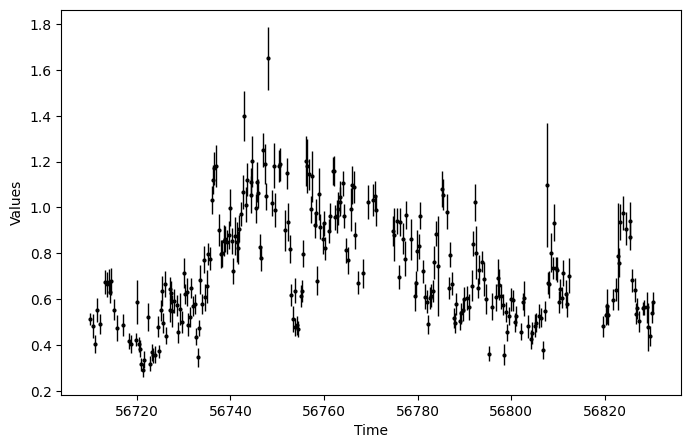

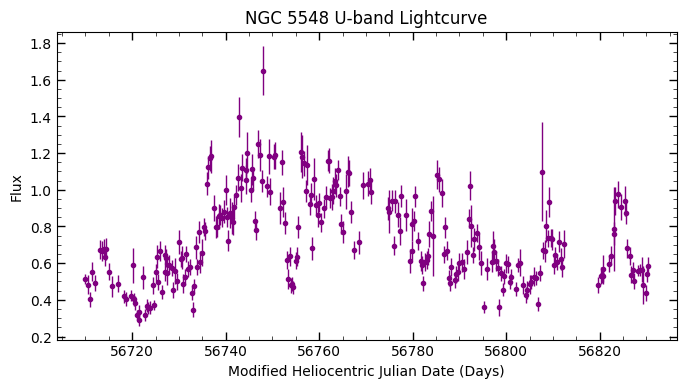

In [38]:
# Import from file
file_path = '/home/clewin/projects/tsi-toolkit/data/'
lightcurve = TimeSeries(file_path = f'{file_path}NGC5548_U_swift.dat')

# ... or import from arrays
data = np.genfromtxt(f'{file_path}NGC5548_X_swift.dat')
lightcurve = TimeSeries(times=data[:,0], values=data[:,1], sigmas=data[:,2])

# Plot easily with the plot method. Nearly every class has a plot method!
lightcurve.plot()

# Want to customize the plot?
# Almost every facet of the plot can be changed with the plot method's kwargs!
# This includes the figure, axes, plot, tick, and saving kwargs.
lightcurve.plot(figsize=(8,4),
                xlabel='Modified Heliocentric Julian Date (Days)', 
                ylabel='Flux',
                xlim = (lightcurve.times[0], lightcurve.times[-1]),
                title='NGC 5548 U-band Lightcurve',
                fig_kwargs={'linewidth':28},
                plot_kwargs={'color':'purple', 'fmt':'o', 'lw':1, 'ms':3},
                major_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':6, 'width':1},
                minor_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':3, 'width':0.5},
                # save=f"{file_path}pretty_plot.png"
                # save_kwargs={'dpi':300}
                )

#### **Data Preprocessing/Cleaning**
-----

The **Preprocessing class** is full of methods for you to explore cleaning your data, including outlier detection, polynomial detrending, trimming, standardization, and removing nans. 
- These methods operate exclusively on the TimeSeries instance we made before, and never on the original data/file!

The key word above is **"explore"**
* *save=False* allows the user to experiment without committing to any changes.
* *plot=True* visualizes these changes.

***Note:*** There is no need to instantiate the Preprocessing class like we did with the TimeSeries class: it is simply a utility class that takes our instance of TimeSeries as an input

Removed 0 NaN points.
(0 NaN values, 0 NaN sigmas)
Removed 11 outliers (4.14% of data).


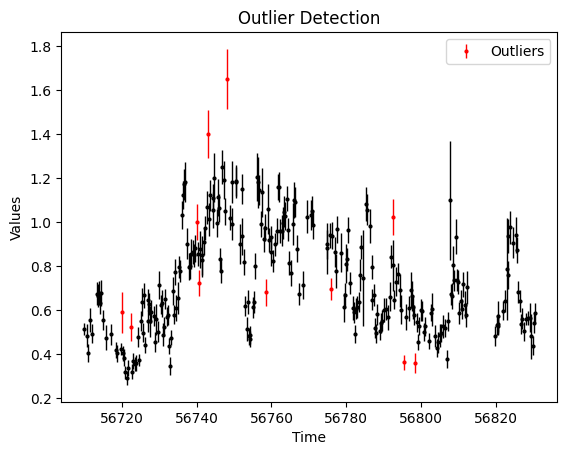

Removed 3 outliers (1.13% of data).


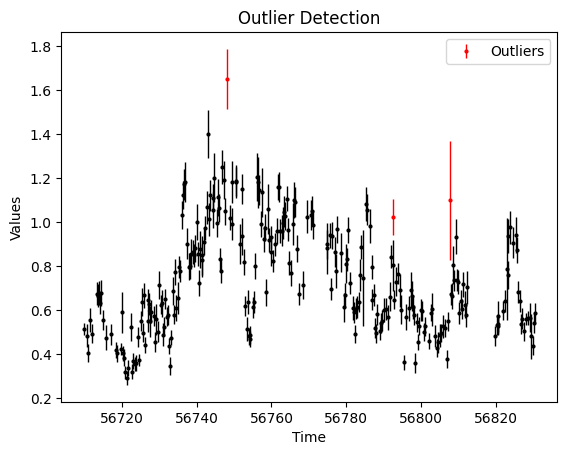

Removed 1 outliers (0.38% of data).


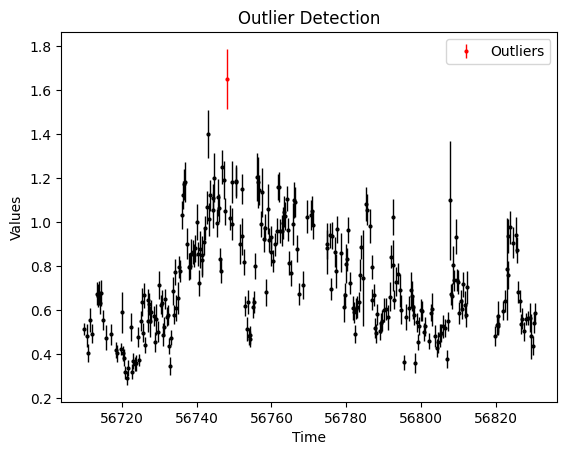

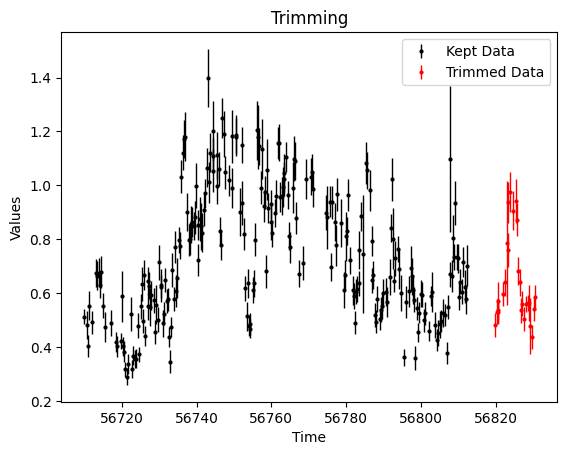

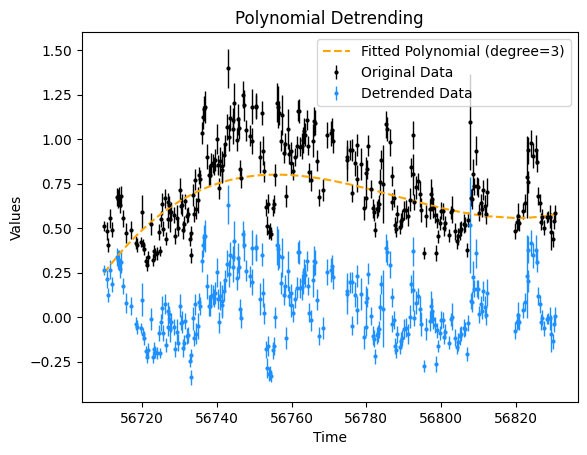

In [39]:
# Remove nans
Preprocessing.remove_nans(lightcurve)

# Remove outliers using the interquartile range (IQR)
# Points beyond threshold*IQR from the median are removed
# Rolling window is the number of points to consider when calculating IQR
# If rolling_window is None, the entire lightcurve is used to calculate IQR
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=10, plot=True, verbose=True, save=False)
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=50, plot=True, verbose=True, save=False)
Preprocessing.remove_outliers(lightcurve, threshold=1.5, rolling_window=None, plot=True, verbose=True, save=True)

# Trim the lightcurve to a specific time segment
Preprocessing.trim_time_segment(lightcurve, end_time=56815, plot=True, save=False)

# Detrend the lightcurve using a polynomial of a specified degree
Preprocessing.polynomial_detrend(lightcurve, degree=3, plot=True, save=False)

# Standardize the lightcurve
Preprocessing.standardize(lightcurve)
Preprocessing.unstandardize(lightcurve)

#### **Introduction to Gaussian Processes**
-----
##### What is a Gaussian Process?
-----

Imagine you want to predict or model a function that describes how something changes over time, in this case the brightness of an AGN. A **Gaussian Process (GP)** is a tool that allows for modeling this function *even if we don't know its exact form.*

* Unlike linear regression, in which we define a fixed function form with parameters that we learn, a GP is a probabilistic framework in which we instead model the data as a collection of random variables (the time series values, flux in this case), where any *subset of these variables follows a joint Gaussian distribution.*
        
    - *Put plainly, this is a prior for the distribution of the data.*

Like any Gaussian, we define the joint Gaussian using a mean and covariance; in this case, functions with parameters that we do learn from the data in order to refine the prior:
- **Mean function $m(t)$:** reflects the expected value at any point in time ($t$).
    - The *mean function* is defined to be 0, as the GP class will standardize your data for you (which is undone at the end to prevent confusion). In doing so, we assume the data has no inherent trend, allowing the GP to learn the structure entirely from the covariance function and observed data.
    
- **Covariance (i.e. Kernel) function $k(t,t')$:** measures how correlated values at different time values ($t,t'$), and hence measures the variability, smoothness, periodicity, etc. We learn properties of the variability by optimizing the **hyperparameters** of this function (e.g., length scales, amplitudes).

##### Optimizing the Hyperparameters of the Kernel Function
-----

The kernel function has infinitely many functional forms, each with their own hyperparameters and their own efficacy in capturing the variability in the data. 

The process of finding the optimal set of hyperparameters that make the observed data most likely, given the GP assumptions, is equivalent to maximizing the log marginal likelihood, or, equivalently, minimizing the **negative log marginal likelihood (NLML)** in this case.
    
- *In Bayesian verbage:* this is optimizing the model evidence and is thus not technically "fitting" to the data in the way we do with non-Bayesian models like linear regression. We avoid maximum likelihood estimation or maximum a posteriori estimation for GPs because they result in overfitting the data.

##### Predictions using GPs
-----

Bayesian inference is at the heart of making predictions at new time points. The GP prior is updated to form the posterior distribution, which can be conditioned on the data that we have observed. 

By *sampling from this posterior distribution*, we can draw realizations that pass through or near the observed data (accounting for noise) while extrapolating plausible behaviors to unobserved points.
* These realizations provide predictions of the function values at new time points, with multiple realizations allowing for intuitive uncertainty in those predictions, reflecting areas where the model is less certain due to a lack of observations.

#### Gaussian Process Models in TSI-Toolkit
-----

We use the **GaussianProcess class** for creating, training, and predicting from a GP model using the TimeSeries instance (the "lightcurve" variable) as an input. 

**Kernels**

* The most common kernel function forms are included in this package, set with "kernel_form".
     
    1. Rational Quadratic (RQ)
    2. Radial Basis Function (RBF)
    3. Three forms of the Matern kernel, each with a different value for the smoothness parameter ($\nu=1/2, 3/2, 5/2$, respectively named Matern12, Matern32, Matern52. *This parameter is not to be confused with a hyperparameter to be optimized!*)
    4. The Spectral Mixture kernel, which is sophisticated and thus included for experimentation.
        - The number of spectral mixtures is a parameter for the user (e.g., "SpectralMixture, 4" sets 4 mixtures). I recommend sticking to the tried-and-true previous kernel forms. 
    
    - To view these functional forms, please refer to the [the GPyTorch documentation](https://docs.gpytorch.ai/en/latest/kernels.html).

**White Noise**

* In addition to accounting for measurement errors (only if provided), the user can fit for white noise by setting "white_noise=True". This adds to the variance only, as expected: $k(x_1, x_1) = \sigma_{noise}^2$.

**Training**

* We optimize the kernel hyperparameters by minimizing the NLML using the ADAM optimizer. For simplicity, this optimizer adjusts the hyperparameter values at each iteration in the direction that results in a lower "loss" (the objective function, NLML in our case).

- The **learning rate** sets the size of the parameter change each iteration (set by the "learn_rate" argument), with the **number of iterations** set by the "num_iter" argument.

    - In most cases, the default values (learn_rate = 0.01, train_iter) should be fine, but it is good practice to confirm the training process results yourself and have confidence in your results!
    - View the training process using "verbose=True" and/or "plot_training=True" to print and/or visualize how the NLML evolves.
    - ***Tip:*** If it is taking forever to converge (monotonically), increase the learning rate. If the hyperparameters are bouncing around a suspected optimum, lower the learning rate. See the image below.
    
    

<img src="./learning_rate.png" style="width:80%;height:auto;">

*Adjusting learning rate based on loss, credit To Jeremy Jordan (https://www.jeremyjordan.me/nn-learning-rate/).*

Iter 1/1000 - Loss: 0.825   lengthscale: 0.744
Iter 2/1000 - Loss: 0.818   lengthscale: 0.795
Iter 3/1000 - Loss: 0.814   lengthscale: 0.835
Iter 4/1000 - Loss: 0.813   lengthscale: 0.861
Iter 5/1000 - Loss: 0.811   lengthscale: 0.870
Iter 6/1000 - Loss: 0.809   lengthscale: 0.865
Iter 7/1000 - Loss: 0.808   lengthscale: 0.851
Iter 8/1000 - Loss: 0.804   lengthscale: 0.832
Iter 9/1000 - Loss: 0.801   lengthscale: 0.810
Iter 10/1000 - Loss: 0.800   lengthscale: 0.788
Iter 11/1000 - Loss: 0.798   lengthscale: 0.767
Iter 12/1000 - Loss: 0.796   lengthscale: 0.749
Iter 13/1000 - Loss: 0.795   lengthscale: 0.735
Iter 14/1000 - Loss: 0.793   lengthscale: 0.724
Iter 15/1000 - Loss: 0.792   lengthscale: 0.716
Iter 16/1000 - Loss: 0.791   lengthscale: 0.710
Iter 17/1000 - Loss: 0.790   lengthscale: 0.705
Iter 18/1000 - Loss: 0.789   lengthscale: 0.700
Iter 19/1000 - Loss: 0.789   lengthscale: 0.695
Iter 20/1000 - Loss: 0.788   lengthscale: 0.690
Iter 21/1000 - Loss: 0.789   lengthscale: 0.684
I

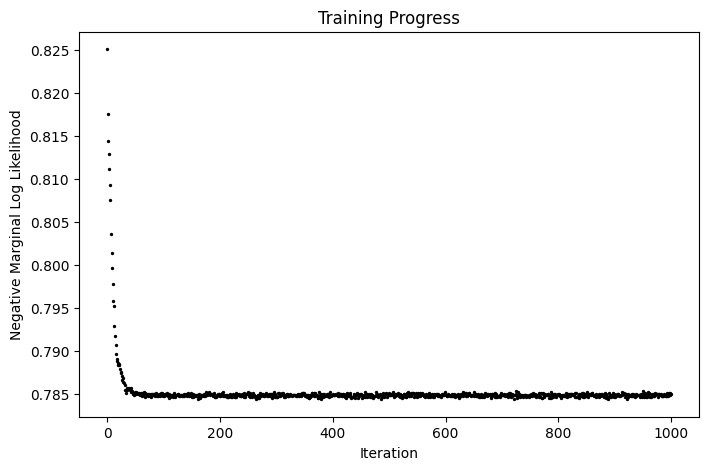

In [ ]:
# Train a Gaussian Process model on the lightcurve, using a Rational Quadratic kernel
# I have included all the relevant arguments for learning purposes, 
# although white_noise, learn_rate, num_iter, and verbose are set to their default values
gp_model = GaussianProcess(timeseries=lightcurve, 
                           kernel_form='RQ', 
                           white_noise=True,
                           learn_rate=1e-1,
                           num_iter=1000,
                           verbose=True,
                           plot_training=True,
                        )
# In other words, the following line would produce the same results as above
# gp_model = GaussianProcess(timeseries=lightcurve, kernel_form='RQ')

# Note the convergence in the loss, and the hyperparameters

In [45]:
# To view the hyperparameters of a model at a later time, use the get_hyperparameters method
gp_model.get_hyperparameters()

# It is good practice to save the model, so that you can load it later for consistency
# Both can be done with the package's save_model and load_model methods
# gp_model.save_model('gp_model.pkl')
# gp_model.load_model('gp_model.pkl')

{'likelihood.second_noise_covar.noise': 0.03931402787566185,
 'covar_module.outputscale': 0.9143790006637573,
 'covar_module.base_kernel.lengthscale': 1.2706692218780518,
 'covar_module.base_kernel.alpha': 0.23910671472549438}


A main motivation for this package was to create a user-friendly method for comparng kernel models.

In [ ]:
gp_model.akaike_inf_crit()


In [ ]:
gp_model = GaussianProcess(timeseries=lightcurve,
                           kernel_form='auto')
#gp_model = GaussianProcess(timeseries=lightcurve,
#                           kernel_form=['RQ', 'Matern12', 'Matern52'])

/home/clewin/.local/lib/python3.12/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:347: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


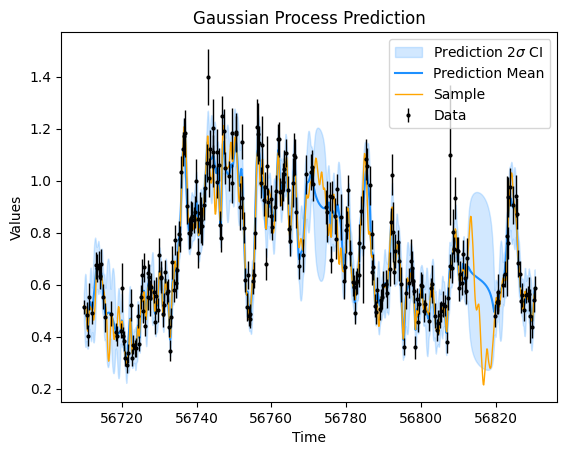

In [54]:
# We can visualize the predictions of the model with the plot method
gp_model.plot()

In [ ]:
prediction_times = np.linspace(lightcurve.times[0], lightcurve.times[-1], 1000)
samples = gp_model.sample(prediction_times, num_samples=1000)

In [ ]:
power_spectrum = PowerSpectrum(times=prediction_times, values=samples, norm=True)
power_spectrum.plot()

power_spectrum.bin(num_bins=13, bin_type="log", save=False, plot=True)

# will add this tomorrow to properly merge those first two bins.
power_spectrum.bin(bin_edges = [])

# let's look at number of frequencies in bins, which can be done for already defined bins (no parameters)
# or we can explore how the frequencies would look in a new binning selection